In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
train = pd.read_csv("C:/Users/Shantanu Ojha/Desktop/nsl-kdd-classical-ids-reproduction/data/raw/KDDTrain+.txt", header=None)
test = pd.read_csv("C:/Users/Shantanu Ojha/Desktop/nsl-kdd-classical-ids-reproduction/data/raw/KDDTest+.TXT", header=None)

In [3]:
columns = [
 'duration','protocol_type','service','flag','src_bytes','dst_bytes','land',
 'wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised',
 'root_shell','su_attempted','num_root','num_file_creations','num_shells',
 'num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
 'count','srv_count','serror_rate','srv_serror_rate','rerror_rate',
 'srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate',
 'dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
 'dst_host_diff_srv_rate','dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate','dst_host_serror_rate',
 'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate',
 'label','difficulty'
]

train.columns = columns
test.columns = columns

In [4]:
train['binary_label'] = train['label'].apply(lambda x: 'normal' if x == 'normal' else 'attack')
test['binary_label'] = test['label'].apply(lambda x: 'normal' if x == 'normal' else 'attack')


In [5]:
attack_map = {
    'normal': 'normal',

    # DoS
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS',
    'smurf': 'DoS', 'teardrop': 'DoS', 'mailbomb': 'DoS',
    'apache2': 'DoS', 'processtable': 'DoS', 'udpstorm': 'DoS',

    # Probe
    'satan': 'Probe', 'ipsweep': 'Probe', 'nmap': 'Probe',
    'portsweep': 'Probe', 'mscan': 'Probe', 'saint': 'Probe',

    # R2L
    'guess_passwd': 'R2L', 'ftp_write': 'R2L', 'imap': 'R2L', 'phf': 'R2L',
    'multihop': 'R2L', 'warezmaster': 'R2L', 'warezclient': 'R2L',
    'spy': 'R2L', 'xlock': 'R2L', 'xsnoop': 'R2L', 'snmpguess': 'R2L',
    'snmpgetattack': 'R2L', 'httptunnel': 'R2L', 'sendmail': 'R2L', 'named': 'R2L',

    # U2R
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'rootkit': 'U2R',
    'perl': 'U2R', 'sqlattack': 'U2R', 'xterm': 'U2R', 'ps': 'U2R'
}

train['attack_category'] = train['label'].map(attack_map)
test['attack_category'] = test['label'].map(attack_map)

In [6]:
X_train = train.drop(columns=['label','difficulty','binary_label','attack_category'])
X_test  = test.drop(columns=['label','difficulty','binary_label','attack_category'])

y_train_bin = train['binary_label']          # normal / attack
y_test_bin  = test['binary_label']

y_train_multi = train['attack_category']     # normal, DoS, Probe, R2L, U2R
y_test_multi  = test['attack_category']

In [7]:
from sklearn.preprocessing import OneHotEncoder
cat_features = ['protocol_type','service','flag']
num_features = [col for col in X_train.columns if col not in cat_features]

ohe = OneHotEncoder(handle_unknown='ignore' ,  sparse_output=False) 

X_train_cat = ohe.fit_transform(X_train[cat_features])
X_test_cat  = ohe.transform(X_test[cat_features])

X_train_num = X_train[num_features].values
X_test_num  = X_test[num_features].values


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train_num)
X_test_num  = scaler.transform(X_test_num)


In [9]:
print(X_train_num.shape)
print(X_train_cat.shape)


(125973, 38)
(125973, 84)


In [10]:
X_train_num = np.asarray(X_train_num)
X_train_cat = np.asarray(X_train_cat)

X_test_num = np.asarray(X_test_num)
X_test_cat = np.asarray(X_test_cat)


In [11]:
print("Train num shape:", X_train_num.shape, "ndim:", X_train_num.ndim)
print("Train cat shape:", X_train_cat.shape, "ndim:", X_train_cat.ndim)


Train num shape: (125973, 38) ndim: 2
Train cat shape: (125973, 84) ndim: 2


In [12]:
X_train_final = np.hstack((X_train_num, X_train_cat))
X_test_final  = np.hstack((X_test_num, X_test_cat))

In [13]:
from sklearn.feature_selection import VarianceThreshold

# Remove features with very low variance
var_selector = VarianceThreshold(threshold=0.01)
X_train_var = var_selector.fit_transform(X_train_final)
X_test_var  = var_selector.transform(X_test_final)

print("Original features:", X_train_final.shape[1])
print("After variance filtering:", X_train_var.shape[1])

# Indices of kept features
selected_var_idx = var_selector.get_support(indices=True)


Original features: 122
After variance filtering: 56


Features with variance below 0.01 were removed as they carry minimal information and may introduce noise, especially for distance-based classifiers.

In [14]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X_train_final, y_train_bin, random_state=42)

mi_df = pd.DataFrame({
    'feature_index': range(len(mi_scores)),
    'mi_score': mi_scores
}).sort_values(by='mi_score', ascending=False)

mi_df.head(10)


,feature_index,mi_score
1,1,0.566035
2,2,0.439792
26,26,0.363287
25,25,0.358942
120,120,0.343879
29,29,0.333580
30,30,0.307043
8,8,0.291031
34,34,0.286897
31,31,0.286765


In [15]:
top_k = 20
top_features = mi_df.head(top_k)['feature_index'].values

X_train_mi = X_train_final[:, top_features]
X_test_mi  = X_test_final[:, top_features]

print("Features after MI selection:", X_train_mi.shape[1])


Features after MI selection: 20


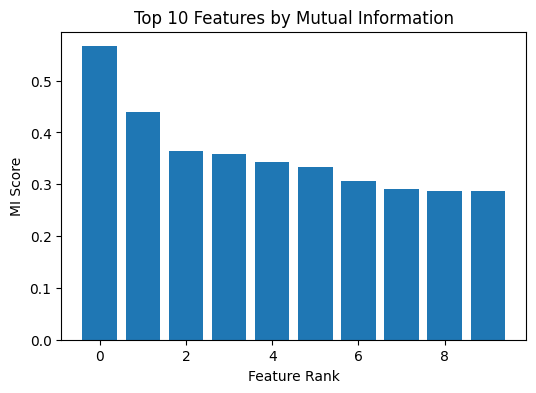

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(range(10), mi_df['mi_score'].head(10))
plt.title("Top 10 Features by Mutual Information")
plt.xlabel("Feature Rank")
plt.ylabel("MI Score")
plt.show()


In [17]:
pd.DataFrame(X_train_final).to_csv("C:/Users/Shantanu Ojha/Desktop/nsl-kdd-classical-ids-reproduction/data/preprocessed/X_train.csv", index=False)
pd.DataFrame(X_test_final).to_csv("C:/Users/Shantanu Ojha/Desktop/nsl-kdd-classical-ids-reproduction/data/preprocessed/X_test.csv", index=False)

y_train_bin.to_csv("C:/Users/Shantanu Ojha/Desktop/nsl-kdd-classical-ids-reproduction/data/preprocessed/y_train_binary.csv", index=False)
y_test_bin.to_csv("C:/Users/Shantanu Ojha/Desktop/nsl-kdd-classical-ids-reproduction/data/preprocessed/y_test_binary.csv", index=False)

y_train_multi.to_csv("C:/Users/Shantanu Ojha/Desktop/nsl-kdd-classical-ids-reproduction/data/preprocessed/y_train_multiclass.csv", index=False)
y_test_multi.to_csv("C:/Users/Shantanu Ojha/Desktop/nsl-kdd-classical-ids-reproduction/data/preprocessed/y_test_multiclass.csv", index=False)

pd.DataFrame(X_train_mi).to_csv("C:/Users/Shantanu Ojha/Desktop/nsl-kdd-classical-ids-reproduction/data/preprocessed/X_train_mi.csv", index=False)
pd.DataFrame(X_test_mi).to_csv("C:/Users/Shantanu Ojha/Desktop/nsl-kdd-classical-ids-reproduction/data/preprocessed/X_test_mi.csv", index=False)

pd.DataFrame(X_train_var).to_csv("C:/Users/Shantanu Ojha/Desktop/nsl-kdd-classical-ids-reproduction/data/preprocessed/X_train_var.csv", index=False)
pd.DataFrame(X_test_var).to_csv("C:/Users/Shantanu Ojha/Desktop/nsl-kdd-classical-ids-reproduction/data/preprocessed/X_test_var.csv", index=False)

In this stage, the raw NSL-KDD dataset was transformed into multiple learning-ready representations to support both reproduction and comparative analysis.

**Label Construction**

Two target formulations were created:

Binary classification: Normal vs Attack

Multiclass classification: Normal, DoS, Probe, R2L, and U2R
All raw attack names were consistently mapped to their respective categories, including attack types present only in the test set.

**Feature Encoding and Scaling**

Categorical attributes (protocol_type, service, flag) were one-hot encoded, and numerical features were standardized using statistics computed only on the training set to prevent data leakage.

**Feature Space Variants**

Instead of relying on a single processed dataset, multiple feature representations were retained for systematic comparison:

Full Feature Set (X_full)
All encoded and scaled features, serving as the baseline representation.

Variance-Filtered Feature Set (X_var)
Near-constant features were removed using variance thresholding to reduce noise and dimensionality.

Mutual Information Selected Feature Set (X_mi)
Features were ranked by their mutual information with the class labels, and the top-K most informative features were retained to study the effect of statistical relevance on detection performance.